# 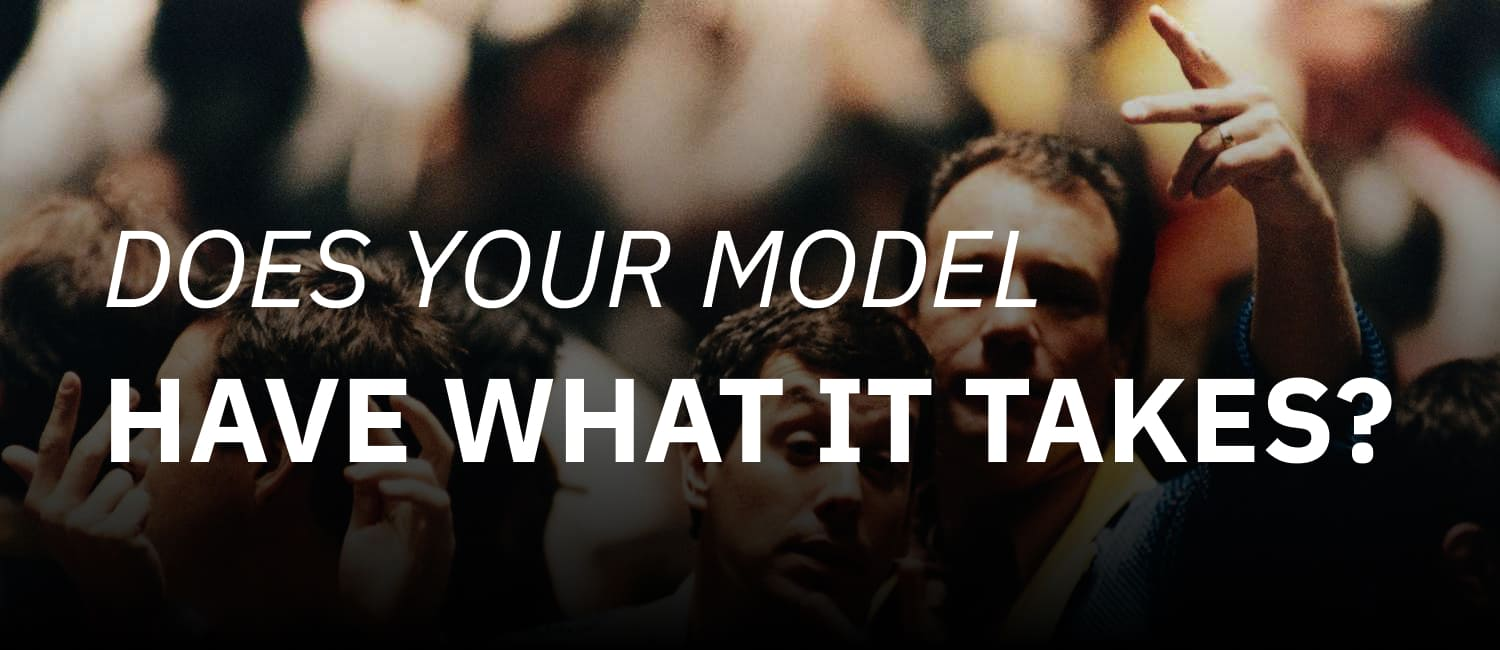

# DataCrunch Code Competition

This EDA notebook will guide you through the design choices and consequential problem statement of the DataCrunch Code Competition.

The previous prediction competition format is changing to a code/model competition format. This change will allow participants not to have to push predictions every week, and for Datacrunch to have a more stable and reliable competition format, enabling the development of a stronger meta-model.

## TL;DR

- The number of features has increased from 615 to 1071.
- `3b1-signal` and `vratios` strategies have been temporary put on-hold for this version of the master dataset, while `fdriver` strategy has been added.
- The average cross-section size has increased.
- There are new targets you can use for training. In particular, target_w is a quantised version of the target that you are scored against. Its value is quantised in 7 bins, following the time-dependent, fat-tailed geometry of returns.
- The `crunch.alpha_score()` function can be called to train and cross-validate directly with a more informative metric called `alpha score`.
- The `spearman` scoring function is dropped in favor of the `alpha score` metric, more alligned with the fund performance.

---

# Libraries

In [1]:
# Install
!pip install crunch-cli --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: crunch-cli
    Found existing installation: crunch-cli 3.0.0
    Uninstalling crunch-cli-3.0.0:
      Successfully uninstalled crunch-cli-3.0.0

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import crunch

import pandas as pd
import numpy as np
import typing
import seaborn as sns
import matplotlib.pyplot as plt
import random

---

# Data

As always, we provide three main DataFrames:

- `X_train` contains the features;
- `y_train` contains the targets;
- `X_test` contains the features used to test your code before pushing to the platform with the command `crunch test`;
- `y_test` contains the targets used to test your code before pushing to the platform with the command `crunch test`;

In [5]:
# Getting the data
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
.crunchdao/project.json: not found, are you in the project directory?
.crunchdao/project.json: make sure to `cd <competition>` first


Abort: 

In [4]:
# Get the features columns
features = [col for col in X_train.columns if 'Feature' in col]

In [ ]:
len(features)

The first difference we can notice is in the number of features: we added new features. Some old ones have also been updated. We decided to put some strategies on-hold: more work is necessary to get the best out of them.

The reference distribution of the features is still Gaussian, with a 7-bins quantization scheme between 0 and 1.

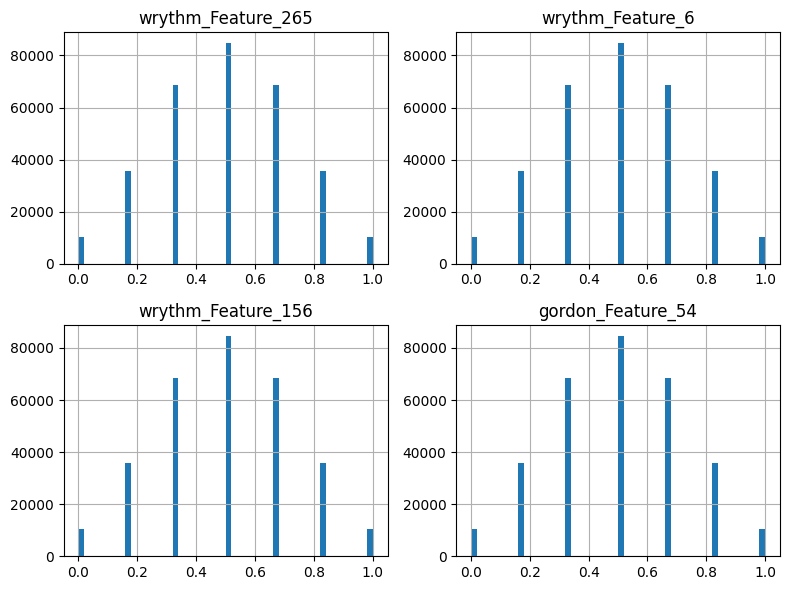

In [8]:
plt_features = random.sample(features, k=4)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for idx, pltt in enumerate(plt_features):
    plt.subplot(2, 2, idx + 1)
    plt.hist(X_train[pltt], bins=50)
    plt.title(pltt)
    plt.grid()

plt.tight_layout()
plt.show()

Here is the covariance matrix of the features evaluated on the first few moons.

In [9]:
cov = X_train.loc[X_train['moon'] < 5, features].corr()

<AxesSubplot: >

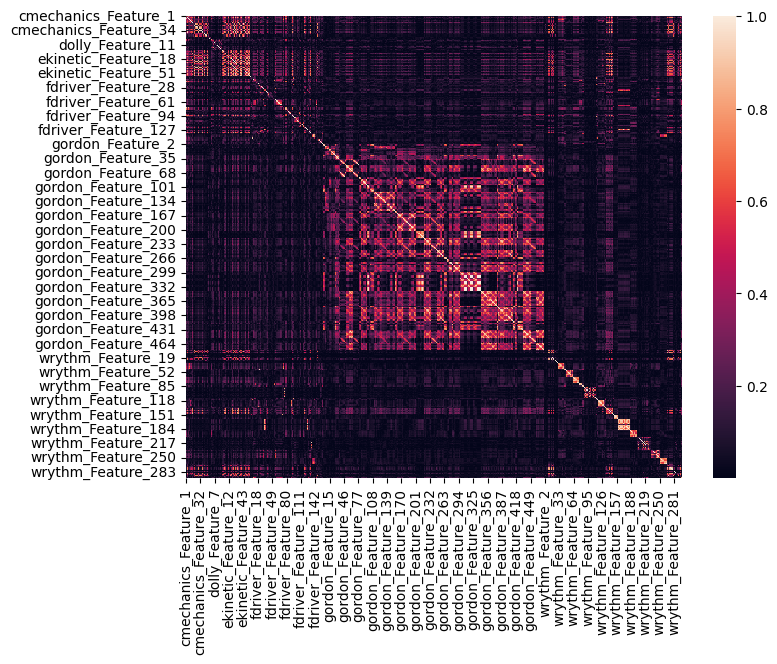

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(cov.abs())

## Universe

In [ ]:
X_train.groupby('moon')['id'].count().plot(figsize=(20, 4))
plt.axhline(y = X_train.groupby('moon')['id'].count().mean(), color = 'r', linestyle = '--')
plt.grid()

The average cross-section size has increased.

In [ ]:
int(X_train.groupby('moon')['id'].count().mean())

In [ ]:
X_train.groupby('moon')['id'].count().max()

---

## Targets

Let’s take a closer look at the targets:

In [ ]:
targets = [col for col in  y_train.columns if 'target' in col]
targets

The targets shared in the dataset have been designed for training. They are quantized 7-bins way to ensure obfuscation.

This choice comes from the experimental evidence that, in order to use supervised learning models to predict on a given target, the use of different, less noisy targets (now called `train_target_` to stress this difference) is beneficial. It also appears that the discrimination of signal and noise is a function of the supervised learning design choices. 

In other words, it is necessary to separate the definition of the objective, from the estimation of the distribution of these objectives, which relies on the identification and estimation of some underlying market invariants [[Meucci 2005]](https://link.springer.com/book/10.1007/978-3-540-27904-4).

We nevertheless stress the importance of the unsupervised step of your work, not only in the space of features, but also targets.

### Target Description

Each train target is associated with a different time window, identified by `_w` (7d), `_r` (28d), `_g` (63d), `_b` (91d), neutralization and quantization scheme [[De Prado 2020]](https://www.cambridge.org/core/elements/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545).

**Targets**:

- `target_w`: moon-wise quantized weekly returns.

- `target_r, _g, _b`: t-student quantized rank of 28, 63, 91 days returns.

- `train_target_r_market_neutral`, `_g_`, `_b_`: neutralized against market.

- `train_target_r_4f_neutral`, `_g_`, `_b_`: neutralized against core risk factors.

- `train_target_r_idiosyncratic`, `_g_`, `_b_`: idiosyncratic targets.

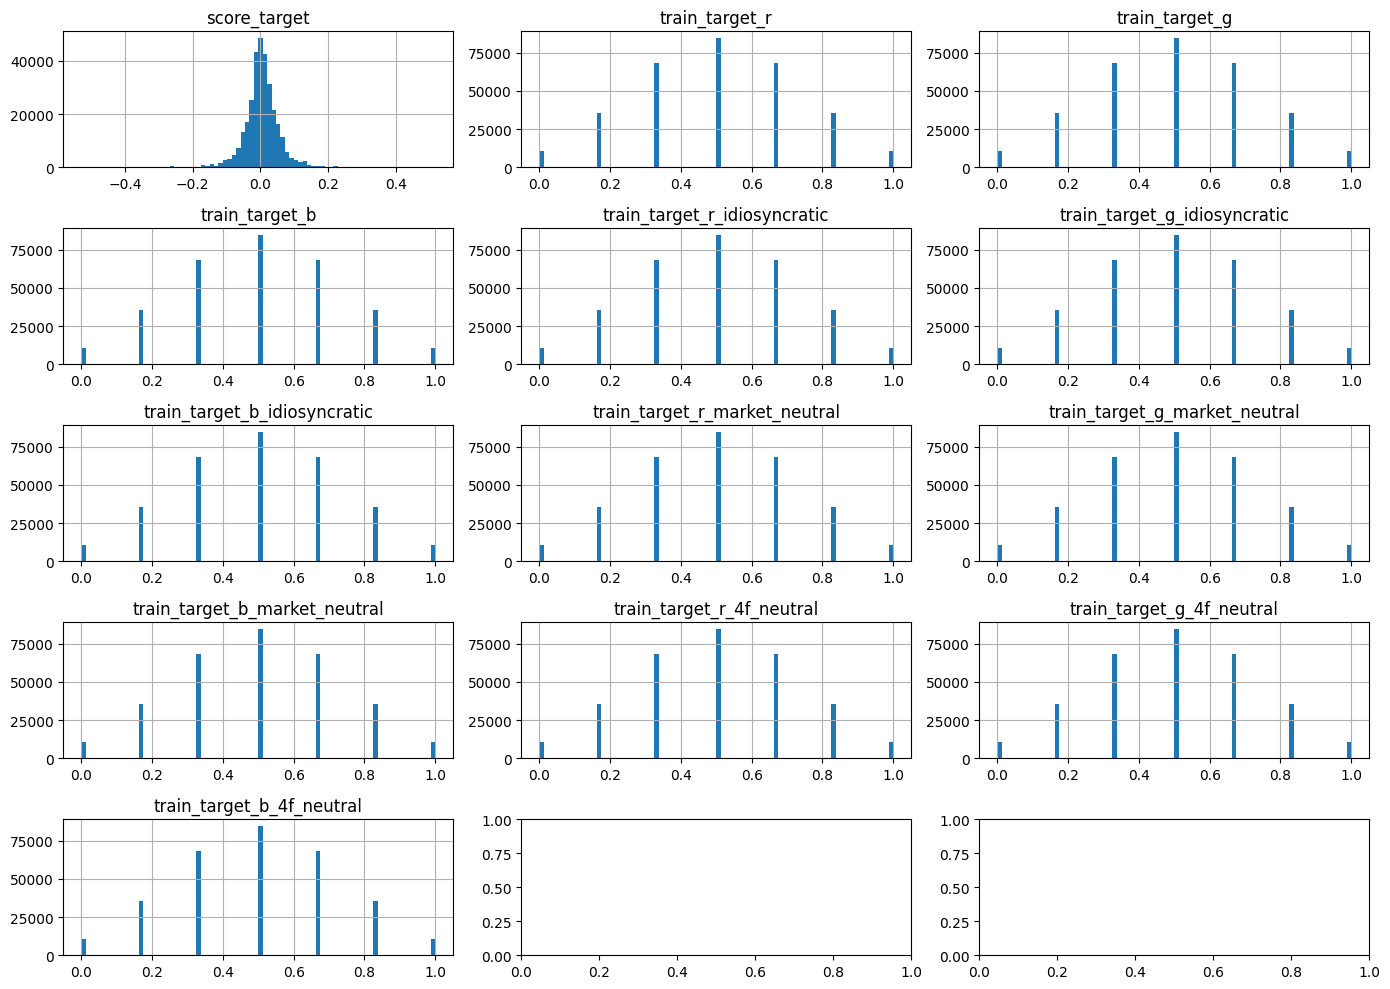

In [19]:
fig, axes = plt.subplots(5, 3, figsize=(14, 10))

for idx, pltt in enumerate(targets):
    plt.subplot(5, 3, idx+1)
    plt.hist(y_train[pltt], bins=80)
    plt.title(pltt)
    plt.grid()

plt.tight_layout()
plt.show()

The scoring target is associated with a weekly timeframe, in line with the current round frequency. 

While predictive capabilities are stronger on longer timeframe targets, a greedy portfolio optimization (even taking into account constraints and costs associated with the product) is associated with a higher-performance, and the use of a weekly target for scoring maximizes the allignment of the problem statement.

Here is the targets covariance matrix:

In [43]:
cov_tg = y_train.iloc[:, 2:].corr()

<AxesSubplot: >

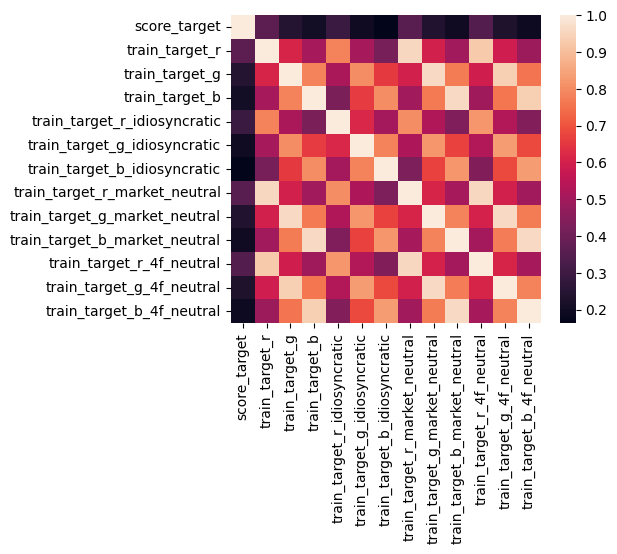

In [44]:
plt.figure(figsize=(5, 4))
sns.heatmap(cov_tg)

Here is the correlation between the scoring target and the various labels.

In [ ]:
cov_tg.iloc[0, 1:].sort_values().plot(kind="barh", color="skyblue", figsize=(5, 4), grid=True)

### Notes on Embargo

Each cross-section is associated with a full week. Each target's initial date is associated with a two-days-shift for execution purposes.
Therefore the necessary embargo is:

In [54]:
embargo_w = np.ceil(2/7)
embargo_w

1.0

In [55]:
embargo_r = np.ceil((28 - 7 + 2)/7)
embargo_r

4.0

In [56]:
embargo_g = np.ceil((63 - 7 + 2)/7)
embargo_g

9.0

In [57]:
embargo_b = np.ceil((91 - 7 + 2)/7)
embargo_b

13.0

---

# Alpha Score API

One of the challenges of crowdsourcing financial machine learning is to frame a problem that is both well-posed statistically and that is alligned with the objective(s) of the financial product. This is further complicated by the necessary data obfuscation.

We have identified and implemented a privacy-preserving methodology, enabling tournament participants to interact with a loss function correlating 84% with the performance of the financial product operating on top of the competition. This is a major improvement in the competition design.

The `crunch.alpha_score()` function can be called from your local environment and from the Crunch Foundation runner to both train and cross-validate.

It expects a dataframe with as columns [`moon`, `id`, `prediction`] and will return a dataframe with `moon` as index and your `alpha-score` score, associated to each moon. You can then compute non-local metrics, like cumulative product, and try to optimize them.

[The alpha_score](https://github.com/crunchdao/crunch-cli/blob/main/crunch/vendor/datacrunch.py#L18) is built as follows:
- gaussianization of your moon prediction vector;
- orthogonalization against risk factors by moon;
- mean-zero transformation by moon;
- l1-norm transformation by moon.

Finally [cross-sectional dot product](https://github.com/crunchdao/crunch-cli/blob/main/crunch/scoring/scorers.py#L73) against the un-obfuscated target.

The use of a non-local metric is key in being able to estimate the covariance structure of the various ML-based alphas, beside reflecting the compounding nature of financial returns.

---

# Alpha Score Function Implementation

## Basic Linear Model Example

In [59]:
from sklearn.linear_model import LinearRegression

df = pd.merge(X_train, y_train, on=['moon', 'id'])

model = LinearRegression()

# 80-20 train-test split
moons = df['moon'].unique()
train_set_moons = moons[:int(len(moons)*0.8)]
test_set_moons = moons[int(len(moons)*0.8 + embargo_w):]
train_set = df[df['moon'].isin(train_set_moons)]
test_set = df[df['moon'].isin(test_set_moons)]

# Fit the model
model.fit(train_set[features], train_set['target_w'])

# Predict
predictions = test_set[['moon', 'id']].copy()
predictions['target_w'] = model.predict(test_set[features])

# Get the alpha score
alpha_score = crunch.alpha_score(predictions)

In [60]:
display(alpha_score.head())

,alpha-score
moon,
229,-0.002539
230,-0.001999
231,-0.000103
232,-0.001176
233,-0.000892


<AxesSubplot: title={'center': 'Cumulative Alpha Score'}, xlabel='moon'>

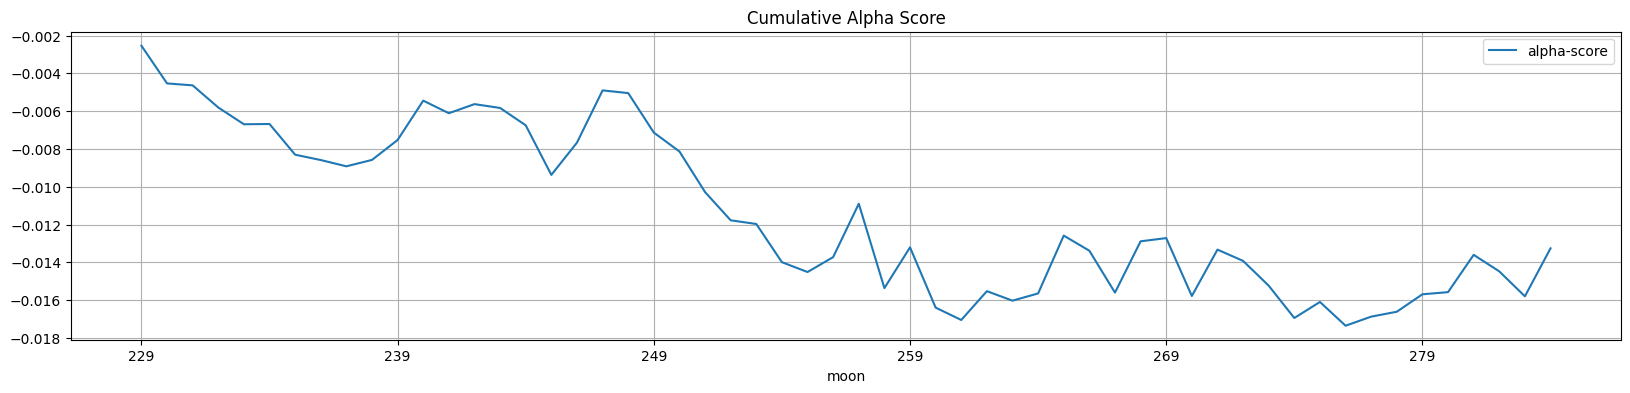

In [61]:
# Plot the cumulative product of the alpha score
(np.cumprod(alpha_score + 1) - 1).plot(title='Cumulative Alpha Score', figsize=(20, 4), grid=True)

In [62]:
# Get the sharpe
print(f"Alpha score sharpe: {(alpha_score.mean() / alpha_score.std()) * np.sqrt(252)}")

Alpha score sharpe: alpha-score   -2.186589
dtype: float64


This vanilla batched linear estimator doesn't seem to perform here. Try to find a better model!

---